In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pwd

Mounted at /content/drive
/content


In [2]:
!ls
%cd drive/MyDrive/DA/clustering
!pwd

drive  sample_data
/content/drive/.shortcut-targets-by-id/16BzENDslJoHpb3XlZqeoy64RYYEZ8ltp/clustering
/content/drive/.shortcut-targets-by-id/16BzENDslJoHpb3XlZqeoy64RYYEZ8ltp/clustering


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from math import pi
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.ensemble import IsolationForest
import seaborn as sn
import math
import collections
from sklearn.cluster import KMeans
np.random.seed(1234)

##Loading Pre-processed Data (Columns with very high correlation are removed)

In [4]:
df_data_pro_names = pd.read_csv('dropped_football_data_with_names.csv', na_values=np.NaN)
print(df_data_pro_names.shape)
display(df_data_pro_names.head())
display(df_data_pro_names.info())
display(df_data_pro_names.describe())

(18147, 50)


,Name,Age,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Jersey Number,Height,Weight,LS,LWB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,GKDiving,Release Clause,Attack Work Rate,Defense Work Rate
0,L. Messi,31,94,94,110.5,565.0,2202,0,5.0,4.0,4.0,1,1,10.0,5.7,159,88.0,64.0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,6.0,226.5,1,1
1,Cristiano Ronaldo,33,94,94,77.0,405.0,2228,1,5.0,4.0,5.0,1,1,7.0,6.2,183,91.0,65.0,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,7.0,127.1,2,0
2,Neymar Jr,26,92,93,118.5,290.0,2143,1,5.0,5.0,5.0,1,1,10.0,5.9,150,84.0,65.0,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,9.0,228.1,2,1
3,De Gea,27,91,93,72.0,260.0,1471,1,4.0,3.0,1.0,0,1,1.0,6.4,168,0.0,0.0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,90.0,138.6,1,1
4,K. De Bruyne,27,91,92,102.0,355.0,2281,1,4.0,5.0,4.0,1,1,7.0,5.1,154,82.0,77.0,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,15.0,196.4,2,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18147 entries, 0 to 18146
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      18147 non-null  object 
 1   Age                       18147 non-null  int64  
 2   Overall                   18147 non-null  int64  
 3   Potential                 18147 non-null  int64  
 4   Value                     18147 non-null  float64
 5   Wage                      18147 non-null  float64
 6   Special                   18147 non-null  int64  
 7   Preferred Foot            18147 non-null  int64  
 8   International Reputation  18147 non-null  float64
 9   Weak Foot                 18147 non-null  float64
 10  Skill Moves               18147 non-null  float64
 11  Body Type                 18147 non-null  int64  
 12  Real Face                 18147 non-null  int64  
 13  Jersey Number             18147 non-null  float64
 14  Height

None

,Age,Overall,Potential,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Body Type,Real Face,Jersey Number,Height,Weight,LS,LWB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,GKDiving,Release Clause,Attack Work Rate,Defense Work Rate
count,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000
mean,25.121122,66.253926,71.324076,264.965851,9.759024,1598.002645,0.768061,1.113297,2.947154,2.361492,0.709484,0.091145,19.546096,5.796225,165.982972,51.363917,51.095443,49.738414,45.550229,52.300766,58.695432,42.912217,55.375158,47.176283,42.866038,52.721386,58.374828,64.612829,64.726236,63.501295,61.839147,63.964292,55.465201,65.091034,63.221579,65.318620,47.113187,55.876068,46.702761,49.962198,53.407781,48.546371,58.651127,47.286053,47.701879,16.616906,209.288246,1.218218,1.086185
std,4.669796,6.913320,6.132286,289.865229,22.030250,272.882706,0.422082,0.394150,0.660498,0.756274,0.576000,0.287822,15.947765,0.450096,15.593388,20.127113,19.980009,18.364255,19.527445,17.381753,14.696075,17.695900,18.912224,18.396009,17.480034,15.325211,16.685643,14.930320,14.651776,14.768956,9.011056,14.136073,17.235534,11.822327,15.896381,12.552479,19.263142,17.366534,20.697462,19.530469,14.146594,15.703113,11.437138,19.900450,21.663630,17.698612,293.407285,0.521755,0.502896
min,16.000000,46.000000,48.000000,0.000000,0.000000,731.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,5.100000,110.000000,0.000000,0.000000,5.000000,2.000000,4.000000,7.000000,4.000000,4.000000,6.000000,3.000000,9.000000,5.000000,12.000000,12.000000,14.000000,21.000000,16.000000,2.000000,15.000000,12.000000,17.000000,3.000000,11.000000,3.000000,2.000000,10.000000,5.000000,3.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000
25%,21.000000,62.000000,67.000000,4.400000,1.000000,1457.000000,1.000000,1.000000,3.000000,2.000000,0.000000,0.000000,8.000000,5.100000,154.000000,48.000000,48.000000,38.000000,30.000000,44.000000,54.000000,30.000000,49.000000,34.000000,31.000000,43.000000,54.000000,57.000000,57.000000,55.000000,56.000000,56.000000,45.000000,58.000000,56.000000,58.000000,33.000000,44.000000,26.000000,38.000000,44.000000,39.000000,51.000000,30.000000,27.000000,8.000000,1.800000,1.000000,1.000000
50%,25.000000,66.000000,71.000000,160.000000,3.000000,1635.000000,1.000000,1.000000,3.000000,2.000000,1.000000,0.000000,17.000000,5.900000,165.000000,57.000000,56.000000,54.000000,49.000000,56.000000,62.000000,44.000000,61.000000,48.000000,41.000000,56.000000,63.000000,67.000000,67.000000,66.000000,62.000000,66.000000,59.000000,66.000000,66.000000,67.000000,51.000000,59.000000,52.000000,55.000000,55.000000,49.000000,60.000000,53.000000,55.000000,11.000000,12.600000,1.000000,1.000000
75%,28.000000,71.000000,75.000000,475.000000,9.000000,1787.000000,1.000000,1.000000,3.000000,3.000000,1.000000,0.000000,26.000000,6.100000,176.000000,64.000000,63.000000,64.000000,62.000000,64.000000,68.000000,57.000000,68.000000,62.000000,57.000000,64.000000,69.000000,75.000000,75.000000,74.000000,68.000000,74.000000,68.000000,73.000000,74.000000,74.000000,62.000000,69.000000,64.000000,64.000000,64.000000,60.000000,67.000000,64.000000,66

In [5]:
df_data_pro = df_data_pro_names.drop(['Name'],axis=1)

##Scaling Data Using Standard Scalar

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_data_pro.values)
X_df = pd.DataFrame(X_scaled)

##Kmeans Class

In [17]:
class MyKmeans(object):
    def __init__(self, k=10, init_centers='forgy', max_itrs=100, dist='l2', tol=1):
        np.random.seed(1234)
        self.K = k 
        self.max_itrs = max_itrs
        self.init_centers = init_centers
        self.tolerance = tol
        self.centroids = None
        self.dist_metric = dist

    def fit(self,data):
        np.random.seed(1234)
        if self.init_centers == 'forgy':
            self.centroids = self.forgy_init(data)
        elif self.init_centers == 'partition':
            self.centroids = self.random_partition(data)
        elif self.init_centers == 'kmpp':
            self.centroids = self.kmeans_plus_plus(data)
        else:
            print("Wrong method")
            return None
            # self.centroids = data[:self.K]
        # print('centriods shape',self.centroids.shape)
        for i in range(self.max_itrs):
            # print('itr',i)
            self.cluster_set = {}
            for i in range(self.K):
                self.cluster_set[i] = []
            distances = None
            if self.dist_metric == 'l1':
                distances = self.manhattan_distance(data)
            elif self.dist_metric == 'l2':
                distances = self.euclid_distance(data,self.centroids)
            # print(distances.shape)
            pred_clusters = np.argmin(distances,axis=1)
            # print('pred_clusters',pred_clusters.shape)
            for c in range(self.K):
                self.cluster_set[c] = data[np.where(pred_clusters==c)]
            # print('distances shape',distances.shape)
            prev_centroids = self.centroids.copy()
            # inc = self.init_centers
            for cluster_no in self.cluster_set:
                self.centroids[cluster_no] = np.mean(self.cluster_set[cluster_no],axis=0)
            
            optimized = True
            for c in range(self.K):
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                change = np.sum(np.abs(current_centroid-original_centroid))
                if change > self.tolerance:
                    optimized = False
                    break
            if optimized:
                break
        # for c in self.classifications:
        #     print(c, len(self.classifications[c]))  
        return self

    def euclid_distance(self, X1, X2):
        all_dists = -2 * np.dot(X1, X2.T) + np.sum(X2**2, axis=1) + np.sum(X1**2, axis=1)[:, np.newaxis]
        return all_dists
    
    def forgy_init(self, X):
        np.random.seed(1234)
        return np.array(X[np.random.choice(range(X.shape[0]), replace = False, size = self.K), :])

    def random_partition(self, X):
        np.random.seed(1234)
        indices = np.random.choice(range(0, self.K), replace=True, size=X.shape[0])
        init_centroids = np.zeros((self.K,X.shape[1]))
        for c in range(self.K):
            init_centroids[c] = np.mean(X[np.where(indices==c)],axis=0)        
        return init_centroids

    def kmeans_plus_plus(self,X):
        np.random.seed(1234)
        centers = []
        X = np.array(X)
        initial_index = np.random.choice(range(X.shape[0]))
        centers.append(X[initial_index, :].tolist())
        # print('center',len(centers),len(centers[0]))
        for i in range(self.K - 1):
            distance = self.euclid_distance(X, np.array(centers))  
            # print('distance',distance.shape)          
            if i == 0:
                pdf = np.abs(distance/np.sum(distance))
                # print('pdf1',pdf.shape)
                centroid_new = X[np.random.choice(range(X.shape[0]), replace = False, p = pdf.flatten())]
            else:
                dist_min = np.min(distance, axis = 1)
                pdf = np.abs(dist_min/np.sum(dist_min))
                # print('pdf2',pdf.shape)
                centroid_new = X[np.random.choice(range(X.shape[0]), replace = False, p = pdf)]
                index_max = np.argmax(dist_min, axis = 0)
                centroid_new = X[index_max, :]
            centers.append(centroid_new.tolist())
        return np.array(centers)

    def manhattan_distance(self, X):
        np.random.seed(1234)
        mdists = np.zeros((self.K,X.shape[0]))
        for c in range(len(self.centroids)):
            mdists[c] = np.sum(np.abs(X - self.centroids[c]),axis=1)
        return mdists.T
                
    def predict(self,data):
        np.random.seed(1234)
        distances = []
        if self.dist_metric == 'l1':
            distances = self.manhattan_distance(data)
        elif self.dist_metric == 'l2':
            distances = self.euclid_distance(data,self.centroids)
        predictions = np.argmin(distances, axis=1)
        return np.array(predictions)
  

##Elbow Method for Finding Optimal Number of Clusters
The lower, the better

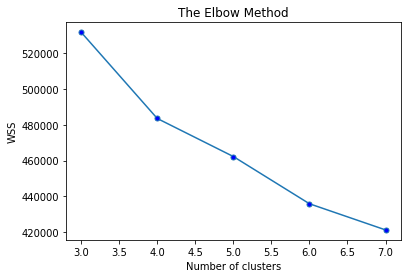

In [18]:
def elbow(X,s,e):
  np.random.seed(1234)
  sse = []
  for k in range(s,e):
    kmeans = MyKmeans(k,'forgy',100,'l2').fit(X)
    centroids = kmeans.centroids
    pred_clusters = kmeans.predict(X)
    curr_sse = 0

    for i in range(len(X)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += np.sum((X[i] - curr_center) ** 2)
      
    sse.append(curr_sse)

  return sse

wss = elbow(X_scaled,3,8)
plt.plot(range(3,8), wss, markersize=5, marker='o',markerfacecolor='blue')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WSS')
plt.show()


##Silhouette Method for Optimal Number of Clusters  
The higher, the better

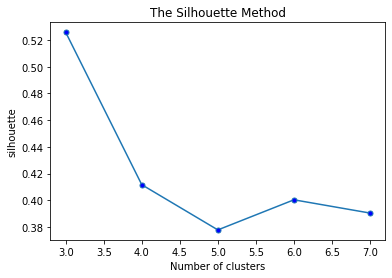

In [21]:
def euclid_distance(test_X, X2):
    all_dists = -2 * np.dot(test_X, X2.T) + np.sum(X2**2, axis=1) + np.sum(test_X**2, axis=1)[:, np.newaxis]
    return all_dists

def silhouette(X,s,e):
    np.random.seed(1234)
    Sk_list = []
    for k in range(s,e):
        kmeans = MyKmeans(k,'forgy',100,'l2').fit(X)
        centroids = kmeans.centroids
        # pred_clusters = kmeans.predict(X)
        centroids = kmeans.centroids
        clusters = kmeans.cluster_set
        center_dists = euclid_distance(centroids,centroids)
        # print('center_dists',center_dists.shape)
        tot_S = []
        for c in range(k):
            cur_cdists = euclid_distance(clusters[c],clusters[c])
            # print('cur_cdists',cur_cdists.shape)
            a = np.sum(cur_cdists,axis=1) / (len(clusters[c])-1)
            nearest_center = np.argmin(np.concatenate((center_dists[c,:c],center_dists[c,c+1:])))
            # print('nearest',len(clusters[nearest_center]))
            nearest_cdists = euclid_distance(clusters[c],clusters[nearest_center])
            # print('nearest_cdists',nearest_cdists.shape)
            b = np.sum(nearest_cdists,axis=1) / (len(clusters[nearest_center]))
            s = None
            if len(clusters[nearest_center]) > 1:
                s = (b - a) / np.max(np.stack((a,b),axis=0),axis=0)
            else:
                s = np.array([0])
            # tot_S = s.sum() / len(s)
            tot_S.append(s.mean())
        Sk_list.append(np.mean(tot_S))
    return Sk_list

sil = silhouette(X_scaled,3,8)
plt.plot(range(3,8), sil, markersize=5, marker='o',markerfacecolor='blue')
plt.title('The Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette')
plt.show()


##Functions for Analysing Clusters  
1) Quality of clusters : Silhoutte score  
2) Detecting outliers : Datapoints having negative silhoutte score  
3) Intracluster distance : Average Complete Diameter  
4) Intercluster distance : Average Linkage Distance  
5) Similar attributes per cluster : Top K attributes having the minimum average difference  
6) Attributes different in outliers : Top K attributes having the maximum average difference  
7) Most discriminative feature between pair of clusters : Max distances between attribute-wise mean (centroids) of the clusters  


In [22]:
def euclid_vectors(X1, X2):
    all_dists = -2 * np.dot(X1, X2.T) + X2**2 + (X1**2)[:, np.newaxis]
    return all_dists

def avg_diameter_dist(kmeans):
    diam = 0
    clusters = kmeans.cluster_set 
    for cl in clusters:
        if cl==-1:
            continue
        cluster = clusters[cl]
        cur_cdists = euclid_distance(cluster,cluster)
        # print("Points in cluster",cl," : ",cur_cdists.shape[0])
        ad = np.mean(cur_cdists)
        diam += ad
    print("\nAverage Complete Diameter (Intracluster) :",diam//kmeans.K)

def avg_linkage_dist(kmeans):
    linkage = 0
    clusters = kmeans.cluster_set 
    for i in clusters:
        c1 = clusters[i]
        j = i+1
        while j < kmeans.K:
            c2 = clusters[j]
            cur_cdists = euclid_distance(c1,c2)
            ad = np.mean(cur_cdists)
            # print(i,j,ad)
            linkage += ad
            j += 1
        i += 1
    print("\nAverage Linkage Distance (Intercluster) :",linkage//kmeans.K)

def silhouette_score(kmeans):
    Sk_list = []
    centroids = kmeans.centroids
    clusters = kmeans.cluster_set
    center_dists = euclid_distance(centroids,centroids)
    tot_S = []
    outliers = []
    for c in range(kmeans.K):
        cur_cdists = euclid_distance(clusters[c],clusters[c])
        a = np.sum(cur_cdists,axis=1) / (len(clusters[c])-1)
        nearest_center = np.argmin(np.concatenate((center_dists[c,:c],center_dists[c,c+1:])))
        nearest_cdists = euclid_distance(clusters[c],clusters[nearest_center])
        b = np.sum(nearest_cdists,axis=1) / (len(clusters[nearest_center]))
        s = None
        if len(clusters[nearest_center]) > 1:
            s = (b - a) / np.max(np.stack((a,b),axis=0),axis=0)
        else:
            s = np.array([0])
        outliers.extend(clusters[c][s<0])
        tot_S.append(s.mean())
    return np.mean(tot_S), np.array(outliers)

def cluster_diff_by(kmeans,cols,t=1):
    clst_means = []
    all_dists = []
    clst_means = kmeans.centroids
    for i in range(len(clst_means)):
        cur_dist = (clst_means - clst_means[i])**2
        for j in range(i+1,len(cur_dist)):
            indx = np.argmax(cur_dist[j])
            print("\nMost discriminative feature in clusters",i,"&",j,": ",cols[indx])


def similar_attributes(kmeans,cols,t=5):
    for cl in kmeans.cluster_set:
        mean_dists = []
        cluster = kmeans.cluster_set[cl]
        for col in range(len(cols)):
            cur_cdists = euclid_vectors(cluster[:,col],cluster[:,col])
            # print(cur_cdists.shape)
            ad = np.mean(cur_cdists)
            mean_dists.append(ad)
        mean_dists = np.asarray(mean_dists)
        indx = np.argsort(mean_dists)[:t]
        print("\nTop K similar features in cluster ",cl," : ",list(cols[indx]))
        print("Name of cluster",cl," : ",tuple(cols[indx])[:3])
        

def diff_attrs_outliers(kmeans,outliers,cols,t=5):
    # outliers = data[labels==-1,:]
    mean_dists = []
    for col in range(len(cols)):
        cur_cdists = euclid_vectors(outliers[:,col],outliers[:,col])
        # print(cur_cdists.shape)
        ad = np.mean(cur_cdists)
        mean_dists.append(ad)
    mean_dists = np.asarray(mean_dists)
    indx = np.argsort(mean_dists)[:t]
    print("\nTop K different features in outliers : ",list(cols[indx]))

##Kmeans With 4 Clusters (Obtained Using Elbow Method)

In [24]:
myk = MyKmeans(4,'forgy',100,'l2').fit(X_scaled)
labels = myk.predict(X_scaled)
counts = collections.Counter(labels)
print(counts)

score, outliers = silhouette_score(myk)
print("\nSilhouette Score:",score,"\nNumber of outliers:",len(outliers))
avg_diameter_dist(myk)
avg_linkage_dist(myk)
similar_attributes(myk,df_data_pro.columns)
cluster_diff_by(myk,df_data_pro.columns)
diff_attrs_outliers(myk,outliers,df_data_pro.columns)

Counter({0: 6020, 3: 5439, 2: 4662, 1: 2026})

Silhouette Score: 0.4116860865279577 
Number of outliers: 867

Average Complete Diameter (Intracluster) : 52.0

Average Linkage Distance (Intercluster) : 216.0

Top K similar features in cluster  0  :  ['Strength', 'Release Clause', 'Value', 'Jersey Number', 'Defense Work Rate']
Name of cluster 0  :  ('Strength', 'Release Clause', 'Value')

Top K similar features in cluster  1  :  ['GKDiving', 'LWB', 'LS', 'BallControl', 'Dribbling']
Name of cluster 1  :  ('GKDiving', 'LWB', 'LS')

Top K similar features in cluster  2  :  ['Wage', 'International Reputation', 'Real Face', 'Overall', 'Reactions']
Name of cluster 2  :  ('Wage', 'International Reputation', 'Real Face')

Top K similar features in cluster  3  :  ['Release Clause', 'Attack Work Rate', 'Preferred Foot', 'Height', 'Body Type']
Name of cluster 3  :  ('Release Clause', 'Attack Work Rate', 'Preferred Foot')

Most discriminative feature in clusters 0 & 1 :  GKDiving

Most discriminativ

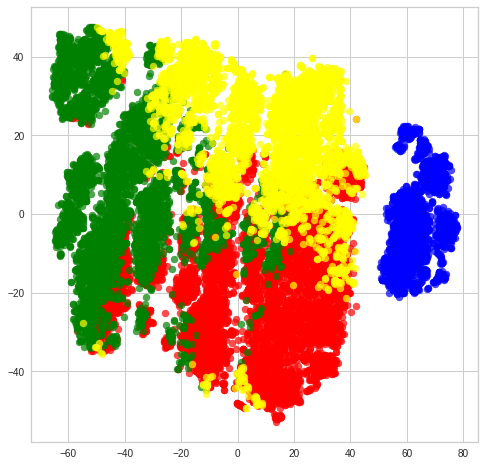

In [ ]:
tsneagg=TSNE(n_components=2, perplexity=50, init='pca', n_iter=1000, random_state=1).fit_transform(X_scaled)
fig=plt.figure(figsize=(8,8))
plt.scatter(tsneagg[labels==0, 0], tsneagg[labels==0, 1], s=50, marker='o', color='red', alpha=0.7)
plt.scatter(tsneagg[labels==1, 0], tsneagg[labels==1, 1], s=50, marker='o', color='green', alpha=0.7)
plt.scatter(tsneagg[labels==2, 0], tsneagg[labels==2, 1], s=50, marker='o', color='blue', alpha=0.7)
plt.scatter(tsneagg[labels==3, 0], tsneagg[labels==3, 1], s=50, marker='o', color='yellow', alpha=0.7)
plt.show()

##Kmeans With 3 Clusters

In [27]:
myk = MyKmeans(3,'forgy',100,'l2').fit(X_scaled)
labels = myk.predict(X_scaled)
counts = collections.Counter(labels)
print(counts)

score, outliers = silhouette_score(myk)
print("\nSilhouette Score:",score,"\nNumber of outliers:",len(outliers))
avg_diameter_dist(myk)
avg_linkage_dist(myk)
similar_attributes(myk,df_data_pro.columns)
cluster_diff_by(myk,df_data_pro.columns)
diff_attrs_outliers(myk,outliers,df_data_pro.columns)

Counter({0: 9182, 2: 6937, 1: 2028})

Silhouette Score: 0.5258771392582859 
Number of outliers: 398

Average Complete Diameter (Intracluster) : 55.0

Average Linkage Distance (Intercluster) : 167.0

Top K similar features in cluster  0  :  ['Release Clause', 'Strength', 'Jersey Number', 'Body Type', 'Attack Work Rate']
Name of cluster 0  :  ('Release Clause', 'Strength', 'Jersey Number')

Top K similar features in cluster  1  :  ['GKDiving', 'LWB', 'LS', 'BallControl', 'Dribbling']
Name of cluster 1  :  ('GKDiving', 'LWB', 'LS')

Top K similar features in cluster  2  :  ['Wage', 'International Reputation', 'Real Face', 'Defense Work Rate', 'Skill Moves']
Name of cluster 2  :  ('Wage', 'International Reputation', 'Real Face')

Most discriminative feature in clusters 0 & 1 :  GKDiving

Most discriminative feature in clusters 0 & 2 :  Overall

Most discriminative feature in clusters 1 & 2 :  LS

Top K different features in outliers :  ['Value', 'Defense Work Rate', 'Attack Work Rate', 'Pr

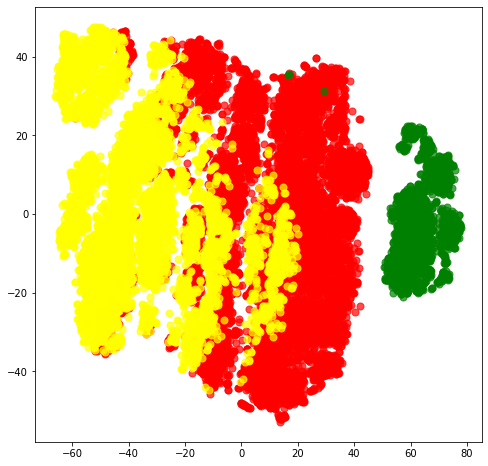

In [28]:
tsneagg=TSNE(n_components=2, perplexity=50, init='pca', n_iter=1000, random_state=1).fit_transform(X_scaled)
fig=plt.figure(figsize=(8,8))
plt.scatter(tsneagg[labels==0, 0], tsneagg[labels==0, 1], s=50, marker='o', color='red', alpha=0.7)
plt.scatter(tsneagg[labels==1, 0], tsneagg[labels==1, 1], s=50, marker='o', color='green', alpha=0.7)
plt.scatter(tsneagg[labels==2, 0], tsneagg[labels==2, 1], s=50, marker='o', color='yellow', alpha=0.7)
plt.show()

##Kmeans With 5 Clusters

In [25]:
myk = MyKmeans(5,'forgy',100,'l2').fit(X_scaled)
labels = myk.predict(X_scaled)
counts = collections.Counter(labels)
print(counts)

score, outliers = silhouette_score(myk)
print("\nSilhouette Score:",score,"\nNumber of outliers:",len(outliers))
avg_diameter_dist(myk)
avg_linkage_dist(myk)
similar_attributes(myk,df_data_pro.columns)
cluster_diff_by(myk,df_data_pro.columns)
diff_attrs_outliers(myk,outliers,df_data_pro.columns)

Counter({3: 4922, 0: 4117, 2: 3652, 1: 3430, 4: 2026})

Silhouette Score: 0.3778107515977429 
Number of outliers: 1117

Average Complete Diameter (Intracluster) : 50.0

Average Linkage Distance (Intercluster) : 260.0

Top K similar features in cluster  0  :  ['Value', 'Defense Work Rate', 'Attack Work Rate', 'Strength', 'Weak Foot']
Name of cluster 0  :  ('Value', 'Defense Work Rate', 'Attack Work Rate')

Top K similar features in cluster  1  :  ['Attack Work Rate', 'Vision', 'Strength', 'Defense Work Rate', 'Release Clause']
Name of cluster 1  :  ('Attack Work Rate', 'Vision', 'Strength')

Top K similar features in cluster  2  :  ['Wage', 'International Reputation', 'Real Face', 'Overall', 'Reactions']
Name of cluster 2  :  ('Wage', 'International Reputation', 'Real Face')

Top K similar features in cluster  3  :  ['Release Clause', 'Overall', 'Jersey Number', 'Preferred Foot', 'Strength']
Name of cluster 3  :  ('Release Clause', 'Overall', 'Jersey Number')

Top K similar features in 

##Kmeans With 7 Clusters

In [26]:
myk = MyKmeans(7,'forgy',100,'l2').fit(X_scaled)
labels = myk.predict(X_scaled)
counts = collections.Counter(labels)
print(counts)

score, outliers = silhouette_score(myk)
print("\nSilhouette Score:",score,"\nNumber of outliers:",len(outliers))
avg_diameter_dist(myk)
avg_linkage_dist(myk)
similar_attributes(myk,df_data_pro.columns)
cluster_diff_by(myk,df_data_pro.columns)
diff_attrs_outliers(myk,outliers,df_data_pro.columns)

Counter({3: 3499, 0: 3386, 5: 2950, 1: 2745, 2: 2652, 4: 2026, 6: 889})

Silhouette Score: 0.39043374616607907 
Number of outliers: 3047

Average Complete Diameter (Intracluster) : 49.0

Average Linkage Distance (Intercluster) : 386.0

Top K similar features in cluster  0  :  ['Defense Work Rate', 'Value', 'Skill Moves', 'Weak Foot', 'Attack Work Rate']
Name of cluster 0  :  ('Defense Work Rate', 'Value', 'Skill Moves')

Top K similar features in cluster  1  :  ['Vision', 'Attack Work Rate', 'Agility', 'Strength', 'Balance']
Name of cluster 1  :  ('Vision', 'Attack Work Rate', 'Agility')

Top K similar features in cluster  2  :  ['Real Face', 'Defense Work Rate', 'Interceptions', 'Marking', 'Attack Work Rate']
Name of cluster 2  :  ('Real Face', 'Defense Work Rate', 'Interceptions')

Top K similar features in cluster  3  :  ['Release Clause', 'Preferred Foot', 'Value', 'Height', 'Body Type']
Name of cluster 3  :  ('Release Clause', 'Preferred Foot', 'Value')

Top K similar features in 